In [2]:
import pandas as pd
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 10)

In [2]:
# Load Data
df = pd.read_csv("../CSVs/MLOps - All.csv")

# Remove columns that will not be used
df.drop(['Source',	'Year',	'# Citations',	'Authors',	'Journal',	'Type',	'PDF',	'BibTex',	'DOI',	'Published',	'Matched_title'], axis = 1, inplace=True)

# Check Nans and drop their rows
print("NaNs")
print(df.isna().sum())

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df.head(3)

NaNs
Title          0
Abstract    1163
dtype: int64


,Title,Abstract
0,Fundamental requirements of a machine learning operations platform for industrial metal additive...,AbstractMetal-based Additive Manufacturing (AM) can realize fully dense metallic components and ...
1,LinkEdge: Open-sourced MLOps Integration with IoT Edge,"MLOps, or Machine Learning Operations, play a significant role in streamlining production deploy..."
2,MLOps Automation – Developing a RESTful API for Text Based Emotion Detection,Identifying the emotional state of a person or group of people by analyzing their written works ...


In [3]:
# Clean text
def clean_text(text):
    text = re.sub(r"[^a-zA-Z]", " ", str(text))
    text = text.lower()
    return text

# Apply cleaning
df['cleaned_Abstract'] = df['Abstract'].apply(clean_text)

Change df['abstracts'] to embeddings using doc2vec. 
- Doc2Vec is an unsupervised learning technique that maps each document to a fixed-length vector in a high-dimensional space.
- The vectors are learned in such a way that similar documents are mapped to nearby points in the vector space.
- This enables us to compare documents based on their vector representation

In [4]:
## Create doc2vec model, train it on df['cleaned_Abstract'], then transform abstract to embeddings
from gensim.models.doc2vec import Doc2Vec,TaggedDocument
from nltk.tokenize import word_tokenize

# Create TaggedDocuments from Abstract
tagged_data = [TaggedDocument(words=word_tokenize(doc), tags=[str(i)]) for i, doc in enumerate(df['cleaned_Abstract'])]

# Create and Train Doc2vec model
model = Doc2Vec(
    vector_size=150, # Dimensionality of the feature vectors.
    window=3, # Maximum distance between the current and predicted word.
    min_count=5, # Ignores all words with a total frequency lower than this.
    workers=4, # Number of worker threads used in training.
    epochs=50,
    dm=1 # Defines the training algorithm (1 for Distributed Memory, 0 for Distributed Bag of Words).
    )

model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Transform docs into embedding vectors using doc2vec model
document_vectors = [model.infer_vector(word_tokenize(doc.lower())) for doc in df['cleaned_Abstract']]

Embeddings will still be very high dimensional for a clustering algorithm. So, we will reduce their dimensionality.

- PCA is one way to reduce dimensionality, when the data can be well understood. But, PCA results are linear and results in a loss of information because only a proportion of the observed variance in the data is retained. We keep the 'highlights', but potentially important differences because they look like 'noise'.

- UMAP (Uniform Manifold Approximation and Projection) embeds the higher-dimensional space into a lower-dimensional one in its entirety. UMAP seeks to preserve both local and global structure — though this balance can be adjusted by playing with the parameters — making it more useful as a precursor to clustering.

- UMAP offers several distance measures for performing dimensionality reduction. Common choices would be the Euclidean, cosine, and Manhattan distances. Where there is wide variation in the number of terms in documents, the cosine distance might be a good choice because it is unaffected by magnitude; very long documents essentially get 'more votes', so that their averaged vectors often prove larger in magnitude than those of shorter documents. While our corpus has variation, fewer than 2% of the records might be considered ‘extreme’ in length so we’ve stuck with Euclidean distance.

- UMAP not only enhance the computational efficiency of algorithms but also mitigate overfitting, as they help focus on the most relevant features and reduce the impact of noise.

In [5]:
import umap
# Reduce dimensionality of the embedding vectors using UMAP
def reduce_dimensionality(document_vectors, n_neighbors=5, n_components=2, metric='cosine', min_dist=0.1, n_epochs= 40):
  reducer = umap.UMAP(
      n_neighbors=n_neighbors, # Controls the balance between local and global structure in the data.
      n_components=n_components, # The number of dimensions to reduce the data to
      metric=metric, # The distance metric used to measure the similarity between points.
      min_dist=min_dist, # Controls how tightly UMAP packs points together. Low values help in clustering. Larger values preserve topological structure.
      n_epochs=n_epochs, # Number of training epochs.
      )

  # Reduce dimensionality of vectorized documents
  embedding = reducer.fit_transform(document_vectors)
  print(f"Samples: {embedding.shape[0]}, Document's Vector: {embedding.shape[1]}")

  return embedding

Samples: 852, Document's Vector: 2


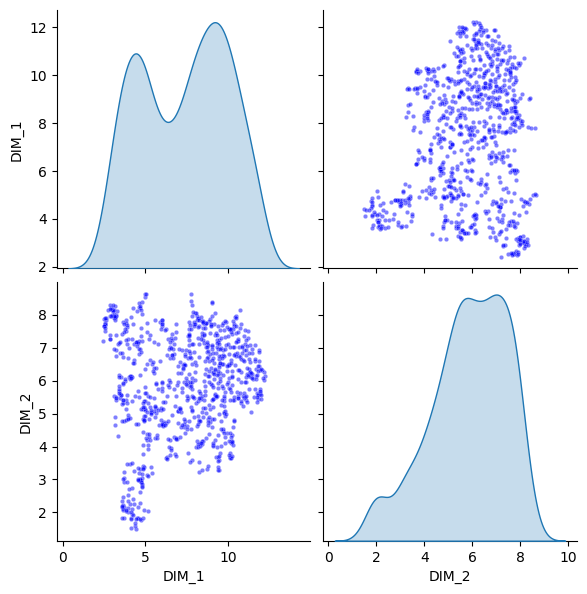

In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
# Get reduced embeddings
embedding = reduce_dimensionality(document_vectors=document_vectors, n_components=2, n_neighbors=5, n_epochs=50)

# Store embeddings into dataframe
df['DIM_1'] = embedding[:, 0]
df['DIM_2'] = embedding[:, 1]

dimensions = ['DIM_1', 'DIM_2']

# Plotting articles' embeddings without clustering
sns.pairplot(df[dimensions], markers='o', plot_kws={'color': 'blue', 'alpha': 0.5, 's': 10}, height=3, diag_kind='kde')
plt.show()

After reducing the dimensionality of the embeddings, we will cluster the reduced embeddings.

In [7]:
def create_dendrogram(data, method='ward'):
  # Perform hierarchical/agglomerative clustering
  agglomerative_clustering = linkage(data, method=method)

  # Create a dendrogram
  plt.figure(figsize=(14, 3))
  dendrogram(agglomerative_clustering)
  plt.title('Dendrogram for Hierarchical Clustering')
  plt.xlabel('Sample Index')
  plt.xticks([])
  plt.ylabel('Distance')
  plt.show()

  return agglomerative_clustering

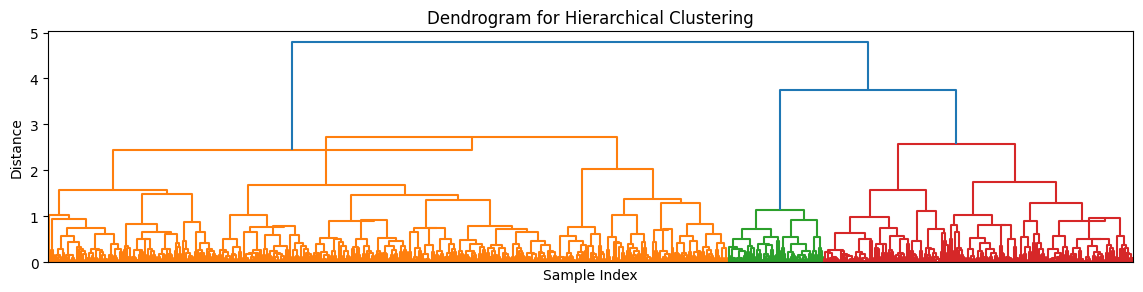

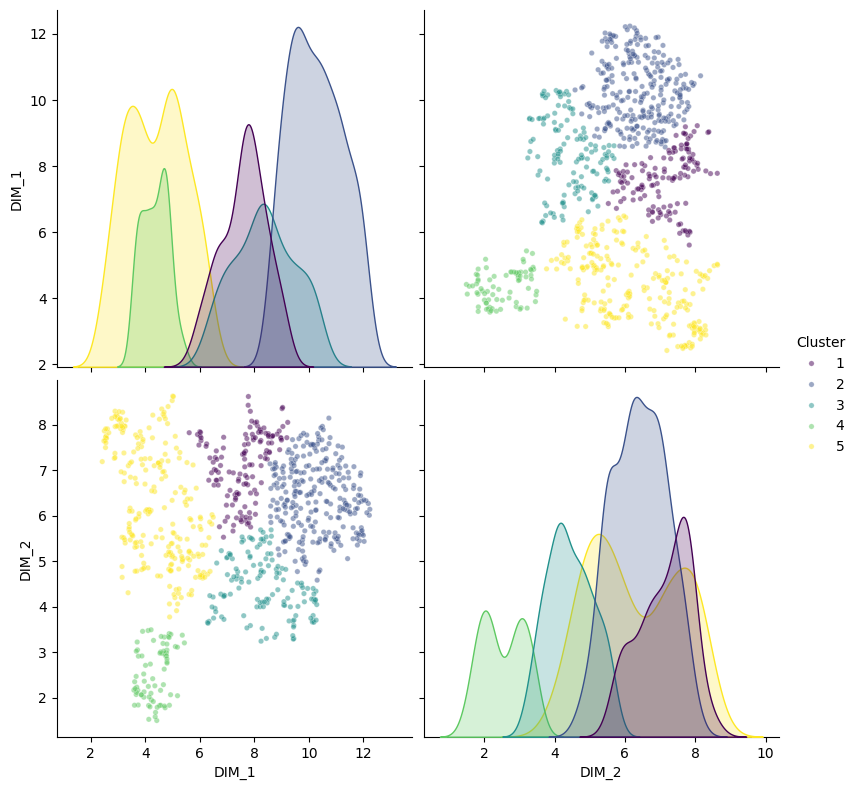

In [8]:
# Cluster dataframe based on the embedding dimensions
agglomerative_cluster = create_dendrogram(df[dimensions].values, method='centroid')

# Get cluster labels
df['Cluster'] = fcluster(agglomerative_cluster, t=5, criterion='maxclust')

# Plot the clusters
clustered_dimensions = dimensions.copy()
clustered_dimensions.append('Cluster')

sns.pairplot(df[clustered_dimensions], plot_kws={'alpha': 0.5, 's': 15}, hue='Cluster', palette='viridis', markers='o', height=4)

plt.show()

In [51]:
# Add cluster keywrods to dataframe as a column
cluster_keywords = [
  "MLOps - Scalability - Continuous Deployment - AI Monitoring - Edge Computing - Operationalization",
  "MLOps - Ethical AI - Machine Learning Lifecycle - Model Deployment - AI Governance - Data Science Automation - Agile Methodologies",
  "MLOps - Industry 4.0 - Machine Learning Operations - Continuous Deployment - AI in Manufacturing - Adoption Challenges",
  "Machine Learning - Deep Learning - Predictive Analytics - Healthcare - Diagnostics - Data Analysis",
  "MLOps - Model Optimization - Reinforcement Learning - Quantum Algorithms - Neural Networks - Privacy-Preserving Techniques"
]

cluster_titles = [
  "MLOps for Scalable, Real-Time Production Systems",
  "Comprehensive MLOps and Responsible AI Practices",
  "Challenges and Applications of MLOps in Industry",
  "Advances in Predictive and Diagnostic Techniques",
  "Advanced Machine Learning Frameworks and Applications"
]

df['Cluster Keywords'] = df['Cluster'].apply(lambda x: cluster_keywords[x - 1])
df['Cluster Titles'] = df['Cluster'].apply(lambda x: cluster_titles[x - 1])

ChatGPT Prompt:
I will give you titles and their clusters.
You will read through all the titles and give me one title for the entire cluster, review this title 1 time and give me a 2nd and final one, then give me up to 6 keywords for this cluster.
You will keep your anserws concise and not explain anything.

GPT output:

1: "MLOps: Integrating Machine Learning into Scalable, Real-Time Production Systems"
"Operationalizing AI: Scalable MLOps for Continuous Deployment and Monitoring"
"End-to-End MLOps: Streamlining Machine Learning in Production"
"Scalable MLOps: Operationalizing Machine Learning for Continuous Deployment"
MLOps - Scalability - Continuous Deployment - AI Monitoring - Edge Computing - Operationalization

2: Comprehensive Guide to MLOps and Responsible AI Development - Advanced MLOps and Responsible AI Practices
"AI-Driven Development and MLOps in Modern Enterprises" - "AI Development, MLOps, and Ethical Practices in Modern Enterprises"
MLOps - Responsible AI - Machine Learning Lifecycle - Model Deployment - AI Governance - Data Science Automation
AI Development - MLOps - Ethical AI - Data Science - Agile Methodologies - Machine Learning

3:  "Challenges and Applications of MLOps in Industry and Beyond" - "MLOps Challenges, Applications, and Adoption in Industry"
MLOps - Industry 4.0 - Machine Learning Operations - Continuous Deployment - AI in Manufacturing - Adoption Challenges

4: "Advances in Predictive and Diagnostic Techniques Using Machine Learning and Deep Learning" 
"Machine Learning and Deep Learning in Predictive Diagnostics and Healthcare"
Machine Learning - Deep Learning - Predictive Analytics - Healthcare - Diagnostics - Data Analysis

5: Advanced Machine Learning Frameworks and Applications - Comprehensive Approaches to Machine Learning Engineering and Applications
MLOps - Model Optimization - Reinforcement Learning - Quantum Algorithms - Neural Networks - Privacy-Preserving Techniques

In [57]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches

# Define colors and create a colormap
colors = ['green', 'red', 'orange', 'cyan', 'blue']
cmap = mcolors.ListedColormap(colors)

def plot_subplot(df, x, y, c, style, cmap, size, labelcolor, legend_title, legend_info, title="Clustered Document Embeddings"):
    plt.style.use(style)

    plt.figure(figsize=(15, 8))
    plt.scatter(x=df[x], y=df[y], c=c, cmap=cmap, alpha=0.7, edgecolors='w', s=size)
    plt.title(title, fontdict={'fontsize': 15})
    plt.grid(True, linestyle='--', color='gray', alpha=0.6)
    
    # Create custom legend
    handles = [patches.Patch(color=colors[i], label=legend_info[i]) for i in range(len(legend_info))]
    plt.legend(handles=handles, title=legend_title, title_fontsize='11', fontsize='10', loc='best', labelcolor=labelcolor)

    # Remove axis lines
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    plt.show()

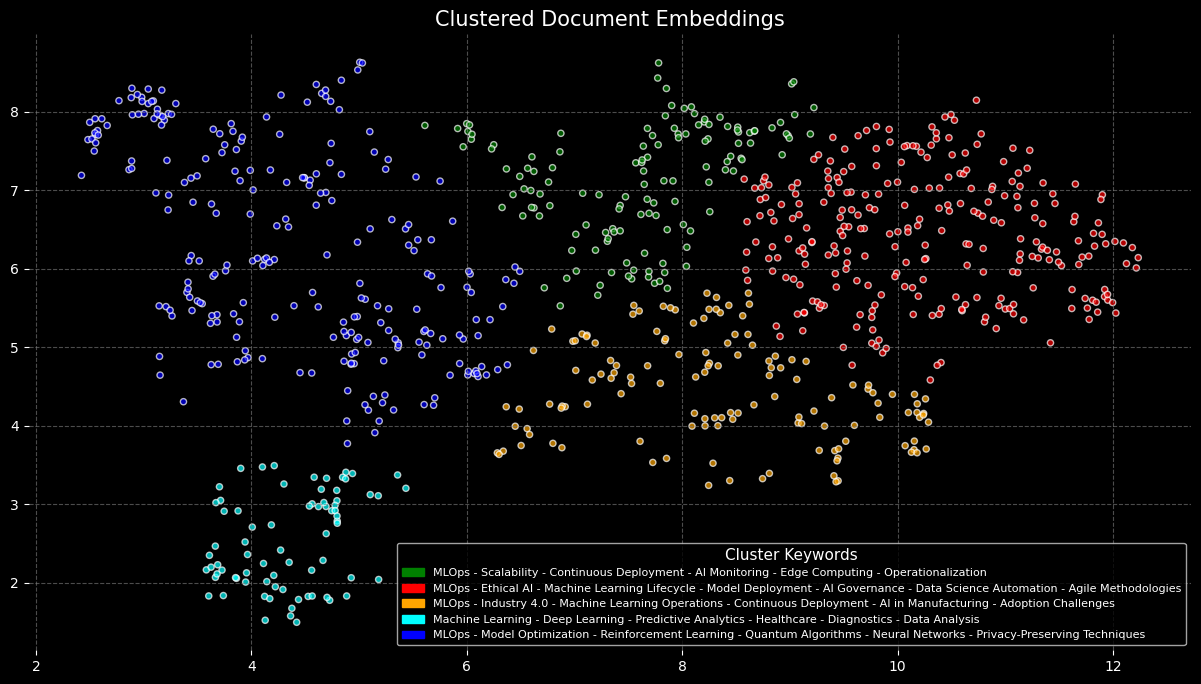

In [52]:
plot_subplot(df=df, x='DIM_1', y='DIM_2', c=df['Cluster'], 
             style='dark_background',  cmap=cmap, size=20, labelcolor='white', 
             legend_info=cluster_keywords, legend_title="Cluster Keywords")

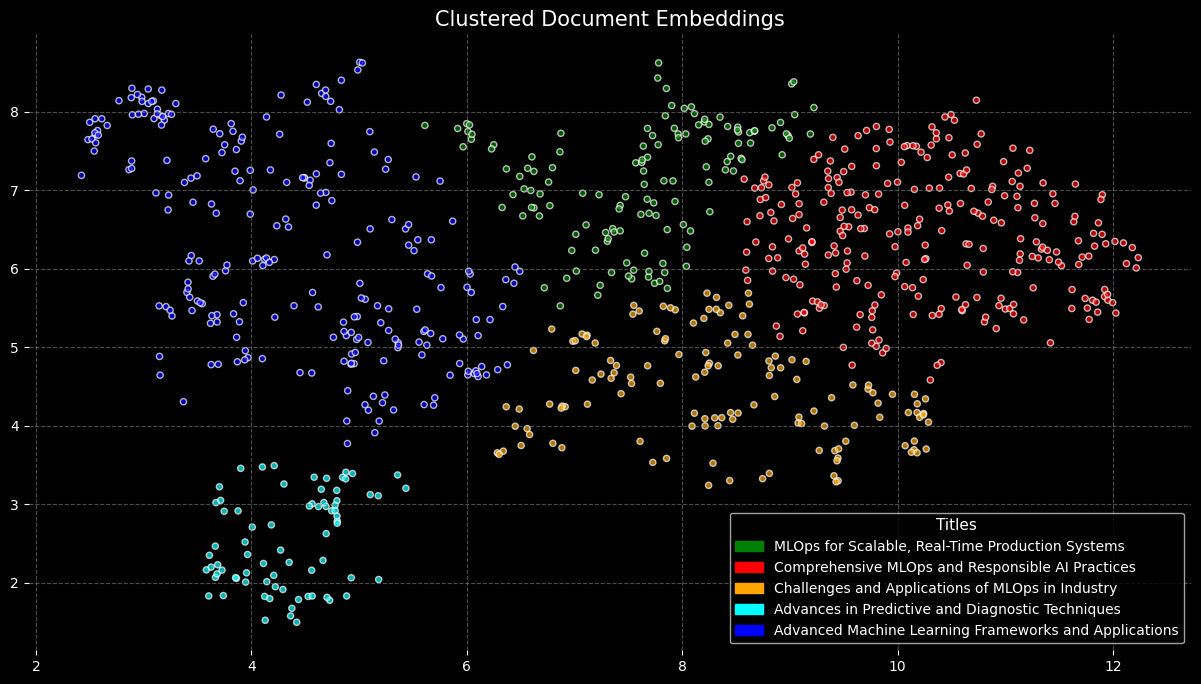

In [58]:
plot_subplot(df=df, x='DIM_1', y='DIM_2', c=df['Cluster'], 
             style='dark_background',  cmap=cmap, size=20, labelcolor='white', 
             legend_info=cluster_titles, legend_title="Titles")